<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2024/Ising2D_Checkerboard_Flax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulation modèle d'Ising 2D par l'algorithme de Checkboard algorithm. Ici c'est une implémentation JAX/FLAX qui tourne mieux sur GPU/TPU.



Voir par ex. https://arxiv.org/pdf/1906.06297.pdf

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import flax
from flax import linen as nn  # Linen API
import jax
import jax.numpy as jnp  # JAX NumPy
from functools import partial

In [3]:
jax.devices()

[cuda(id=0)]

In [ ]:
# theory
Tc = 2/jnp.log(1+jnp.sqrt(2))
def M(t):
  return jax.lax.select(t<Tc,jnp.power((1.0-1.0/jnp.power(jnp.sinh(2.0/t),4)),1/8.0),0.)
vM = jax.vmap(M)

In [ ]:
print("Critical Temp. (th):",Tc)

In [4]:
def kernel_init(key,shape, dtype=jnp.float32):
  # Kernel initialization dans le format de FLAX
  kernel = jnp.zeros((3,3))
  kernel = kernel.at[0,1].set(1.0)
  kernel = kernel.at[1,0].set(1.0)
  kernel = kernel.at[1,2].set(1.0)
  kernel = kernel.at[2,1].set(1.0)
  return kernel.reshape(3,3,1,1) # [kH, kW, inC, outC] (FLAX Conv kernel conv)

In [5]:
class Ising(nn.Module):
  def setup(self):
      self.features = nn.Conv(features=1, kernel_size=(3,3), strides=1, padding=0, use_bias=False,
                         kernel_init=kernel_init)
  def __call__(self, x):
    shape = (x.shape[0],x.shape[1]+2,x.shape[2]+2,x.shape[3])
    t = jnp.zeros(shape=shape) # NHWC FLAX conv
    # padding cyclic (noy yet implemented neither in JAX neither in FLAX)
    t = t.at[:,1:-1,1:-1,:].set(x)
    t = t.at[:,0,1:-1,:].set(x[:,-1,:,:])
    t = t.at[:,-1,1:-1,:].set(x[:,0,:,:])
    t = t.at[:,1:-1,0,:].set(x[:,:,-1,:])
    t = t.at[:,1:-1,-1,:].set(x[:,:,0,:])
    t = t.at[:,0,0,:].set(x[:,-1,-1,:])
    t = t.at[:,-1,-1,:].set(x[:,0,0,:])
    t = t.at[:,-1,0,:].set(x[:,0,-1,:])
    t = t.at[:,0,-1,:].set(x[:,-1,0,:])
    return -x*self.features(t)

In [6]:
@jax.jit
def aimant_stat(lattice):
  # calcul de l'aimantation moyenne sur l'ensemble des realisations de spin
  lattice = lattice.reshape(lattice.shape[0],-1)
  all_m = jnp.mean(lattice,axis=1)
  return (jnp.mean(all_m), jnp.std(all_m))  #aimantation moyenne et std error


# First trial

A quoi rensemble de reseau à "l'équilibre"? Comment évolue l'aimantation durant la génération de la chaine de Markov.
Plus on s'approche de la temérature critique, plus le temps de mise à l'équilibre est long.

A basse température ( $ T<T_c $ ) si le réseau est initilisé àléatoirement, alors les spins ont tendance à s'aligner sur l'orientation de leurs voisins. On a a alors une image avec des grandes zones noires ou blanches. Si le réseau est initialisé avec tous les spins ayant la valeur (+1) alors a fortiori, il reste dans cette configuration. Dans cette configuration, l'amantation moyenne par spine est donc 1.

A haute temperature ( $T>T_c$ ) peut importe l'initialisation du réseau, la configuration finale est une collection de spins dont l'orientation est aléaoire. L'aimantation moyenne est nulle.

Aux aléntoures de la température critique, on a un brusque changment de valeurs de l'aimantation moyenne.



In [86]:
N = 128 #lattice size N x N
temperature = 1.0 # temperature critique 2.2691853
batch = 32 #batch size

In [87]:
# init random numbers
key = jax.random.PRNGKey(42)


# By default the lattice is initialised with all spin up
lattice = jnp.ones(shape=(batch,N,N,1),dtype=jnp.float32)  # NHWC FLAX conv

#decomment the next lattice init. to see the difefrence
#if the lattice is randomly initialized
#lattice = jax.random.rademacher(key,shape=(batch,N,N,1),dtype=jnp.float32)



ones = jnp.ones_like(lattice)
# checkerboads
l = N//2
cb1 = jnp.array([[0., 1.] * l, [1., 0.] * l] * l).reshape(1,N,N,1)
cb2 = jnp.array([[1., 0.] * l, [0., 1.] * l] * l).reshape(1,N,N,1)
# FLax model that implements the short range interaction as a local convolution
model = Ising()
params=model.init(key,lattice)


# jit the application of the model
model_apply = jax.jit(lambda p, x: model.apply(p, x))

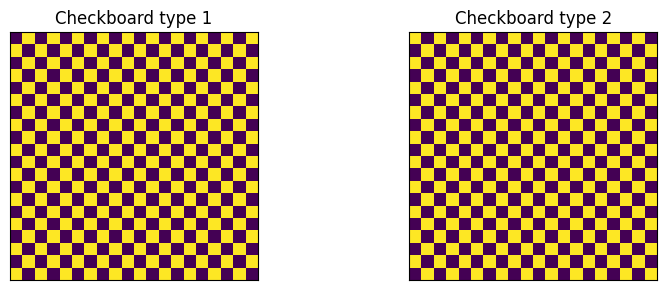

In [88]:
fig,(ax1,ax2) = subplots(1,2,figsize=(9,3))
ax1.matshow(cb1.squeeze()[:20,:20])
ax1.set_xticks([]);ax1.set_yticks([])
ax1.set_title("Checkboard type 1")
ax2.matshow(cb2.squeeze()[:20,:20])
ax2.set_xticks([]);ax2.set_yticks([])
ax2.set_title("Checkboard type 2")
plt.tight_layout()

In [89]:
mag = []
errmag = []

for _ in range(100):

    #checkerboard - update cb 1
    energy = model.apply(params,lattice)
    key, key1a,key1b = jax.random.split(key,num=3)
    new_state = cb2*lattice \
      + cb1*(jax.random.rademacher(key1a,
                                  shape=(batch,N,N,1)))
    new_energy = model_apply(params,new_state)
    deltaE = new_energy - energy
    p = jnp.exp(-deltaE/temperature)
    p = jnp.where(p > 1.0, ones, p)
    r = jax.random.uniform(key1b,shape=(1,N,N,1),dtype=lattice.dtype)
    p = (p-r)*cb1
    lattice = jnp.where(p > 0, new_state, lattice)

    #checkerboard - update cb 2
    key, key2a,key2b = jax.random.split(key,num=3)
    energy = model.apply(params,lattice)
    new_state = cb1*lattice \
     + cb2*(jax.random.rademacher(key2a,
                                  shape=(batch,N,N,1)))
    new_energy = model_apply(params,new_state)
    deltaE = new_energy - energy
    p = jnp.exp(-deltaE/temperature)
    p = jnp.where(p > 1.0, ones, p)
    r = jax.random.uniform(key1b,shape=(1,N,N,1),dtype=lattice.dtype)
    p = (p-r)*cb2
    lattice = jnp.where(p > 0, new_state, lattice)
    m,errm = aimant_stat(lattice)
    mag.append(m)
    errmag.append(errm)



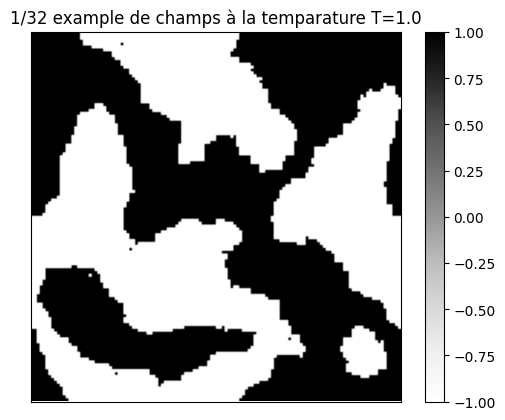

In [90]:
#show lattice as a image
img = lattice[0].squeeze()
imshow(img,cmap='Greys'); colorbar();
xticks([]);yticks([])
title(f"1/{batch} example de champs à la temparature T={temperature:.3}");

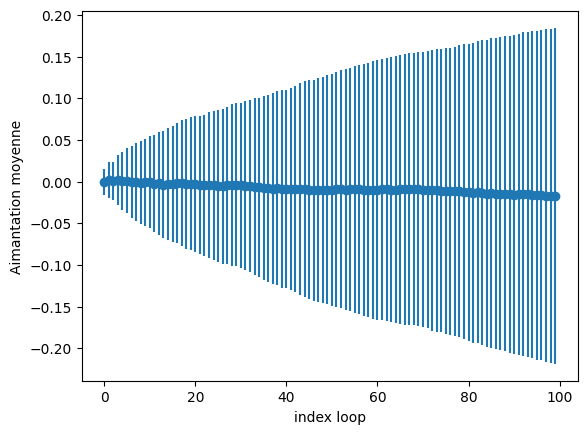

In [91]:
plt.errorbar(np.arange(len(mag)),mag,yerr=errmag,fmt='-o')
plt.xlabel("index loop")
plt.ylabel("Aimantation moyenne");

# Courbe de Magnétisation en fonction de la température

In [14]:
@partial(jax.jit, static_argnums=(1,))
def boucle(key,nloops,lattice,temperature):

    def update_lattice(i,val):
      key,lattice = val
      N = lattice.shape[1]
      #checkerboard - update color 1
      energy = model_apply(params,lattice)
      key, key1a,key1b = jax.random.split(key,num=3)
      new_state = cb2*lattice \
        + cb1*(jax.random.rademacher(key1a,
                                  shape=(batch,N,N,1)))
      new_energy = model_apply(params,new_state)
      deltaE = new_energy - energy
      p = jnp.exp(-deltaE/temperature)
      p = jnp.where(p > 1.0, ones, p)
      r = jax.random.uniform(key1b,shape=(1,N,N,1),dtype=lattice.dtype)
      p = (p-r)*cb1
      lattice = jnp.where(p > 0, new_state, lattice)

      #checkerboard - update color 2
      key, key2a,key2b = jax.random.split(key,num=3)
      energy = model_apply(params,lattice)
      new_state = cb1*lattice \
        + cb2*(jax.random.rademacher(key2a,
                                  shape=(batch,N,N,1)))
      new_energy = model_apply(params,new_state)
      deltaE = new_energy - energy
      p = jnp.exp(-deltaE/temperature)
      p = jnp.where(p > 1.0, ones, p)
      r = jax.random.uniform(key1b,shape=(1,N,N,1),dtype=lattice.dtype)
      p = (p-r)*cb2
      lattice = jnp.where(p > 0, new_state, lattice)
      return (key,lattice)

    _,lattice = jax.lax.fori_loop(0,nloops,update_lattice,(key,lattice))
    return lattice




In [7]:
# theory
Tc = 2/jnp.log(1+jnp.sqrt(2))
def M(t):
  return jax.lax.select(t<Tc,jnp.power((1.0-1.0/jnp.power(jnp.sinh(2.0/t),4)),1/8.0),0.)
vM = jax.vmap(M)

In [24]:
N = 128 #lattice size N x N
batch = 32 #batch size

l = N//2
# init with all spins with +1
lattice = jnp.ones(shape=(batch,N,N,1),dtype=jnp.float32)
ones = jnp.ones_like(lattice)
cb1 = jnp.array([[0., 1.] * l, [1., 0.] * l] * l).reshape(1,N,N,1)
cb2 = jnp.array([[1., 0.] * l, [0., 1.] * l] * l).reshape(1,N,N,1)

key = jax.random.PRNGKey(42)

model = Ising()
params=model.init(key,lattice)

# jit the application of the model
model_apply = jax.jit(lambda p, x: model.apply(p, x))

In [18]:
def simul(key,T, nloops):
    lattice = jnp.ones(shape=(batch,N,N,1),dtype=jnp.float32)  # NHWC FLAX conv
    lattice = boucle(key,nloops,lattice,T)
    return aimant_stat(lattice)


In [19]:
T1 = jnp.array([0.1,0.5, 1.5])
T2 = jnp.linspace(1.5, 2.5, 10)
T3 = jnp.array([3.0,3.5,4.,4.5,5.])
Temperature = jnp.hstack((T1,T2,T3))

In [20]:
N1 = [100] * len(T1)
N2 = [10_000] * len(T2)
N3 = [100] * len(T3)
nloops = jnp.array(N1+N2+N3)

In [21]:
keys = jax.random.split(key,len(Temperature))

In [22]:
aimants = jax.jit(jax.vmap(simul))(keys,Temperature,nloops)

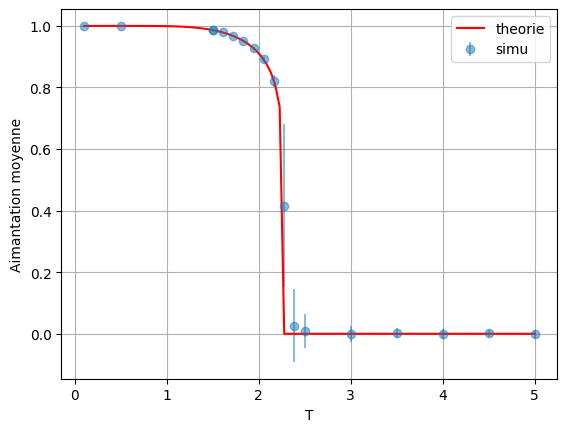

In [26]:
plt.errorbar(Temperature,aimants[0],yerr=aimants[1],fmt='o',alpha=0.5,label="simu")
t = np.linspace(Temperature[0],Temperature[-1],100)
plt.plot(t,vM(t),color="r",label="theorie")
grid()
xlabel("T")
ylabel("Aimantation moyenne")
legend();

ON voit bien la transition de phase mais également, l'erreur sur l'aimantation traduit que le réseau n'est pas forcément à l'équilibre au bout du cycle. Mais celà demanderait plus de d'iérations.

Pour aller plus loin:
1) en fait on simule une chaine de Markov, dès lors que l'on a acquis l'équilibre, normalement tous les échantillons sont iid et peuvent être utiliser pour calculer le moemnt magnetique moyen. Plus on accumule d'échantillons, plus l'estimation de l'espérance doit être meilleure (1/sqrt(n)).
2) il y a d'autres paramètres que l'on peut calculer au-delà de l'aimantation.
3) commenter la génération des nombres aléatoires...
